## ISYE 6740 - Assignment 3 - Clustering

Run the following block to hide all the output warnings:

In [101]:
import warnings
warnings.filterwarnings('ignore')

In [102]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Q1) K-means

* For this question, the dataset used for training is collected from three different Gaussian distributions. Each data point is in $\mathrm{R}^2$. We will use this dataset to study k-means clustering.

* Recall that the goal of k-means is to learn a partition of clusters $\{ \hat{S}_1, \hat{S}_2, \ldots, \hat{S}_k \}$ and the center $\hat{\mu}_i$ for each partition $\hat{S}_i$ such that the the sum of within cluster sum of square distance to the center is minimized, i.e.
\begin{equation}\label{eq}
(\hat{S}_1, \ldots, \hat{S}_k,\hat{\mu}_1, \ldots, \hat{\mu}_k) = \text{argmin}_{S_1, \ldots, S_k,\mu_1, \ldots, \mu_k} \sum_{i=1}^k \sum_{j \in S_i}\| \mu_i - x_j\|_2^2.
\end{equation}

* Please refer to the following package for K-means:\
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [103]:
df1_train = pd.read_csv('./Question_1_training.csv')

#### a) Plot and color all data points of the provided dataset by the ground truth labels.

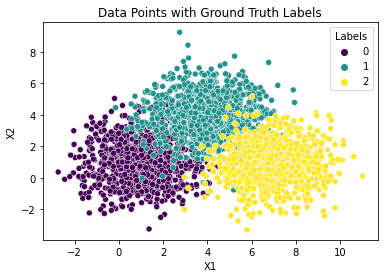

In [104]:
# Create a scatter plot with the third column as hue
sns.scatterplot(data=df1_train, x=df1_train.iloc[:, 0], y=df1_train.iloc[:, 1], hue=df1_train['Label'], palette='viridis')

# Add labels and a legend
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data Points with Ground Truth Labels')
plt.legend(title='Labels')

# Show the plot
plt.show()

#### b) Apply the k-means method to the dataset, and compute the objective value of the output (the sum of within cluster sum of square distance to the center) using k=1,2,3,4,5,6. Then plot objective value vs. k. What do you observe?

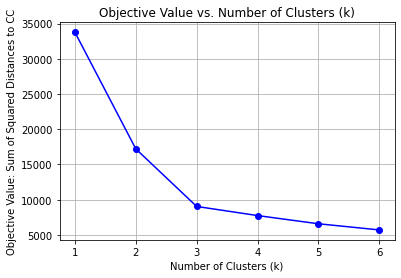

In [105]:
from sklearn.cluster import KMeans

k_values = range(1, 7)  # Range of k values to try
objective_values = []  # To store the computed objective values
# kmeans.inertia_: Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df1_train.iloc[:, :2])  # Fit K-Means with k clusters
    objective_values.append(kmeans.inertia_)  # Inertia is the objective value

plt.plot(k_values, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Objective Value: Sum of Squared Distances to CC')
plt.title('Objective Value vs. Number of Clusters (k)')
plt.grid(True)
plt.show()


Given our original dataset, we know that the ground truth consists of three different clusters. In fact, the graph above shows the largest reduction in the sum of squared distances of samples to their closest cluster center happens within the first three clusters. After that point, the 'error minimization' process slows down; however, it continues because, with an increasing number of k, the data points get closer to one of the cluster centers.

#### c) Plot and color all data points by the clustering results for k=1,2,3,4,5,6. How do these plots compare to that under the ground truth labels?

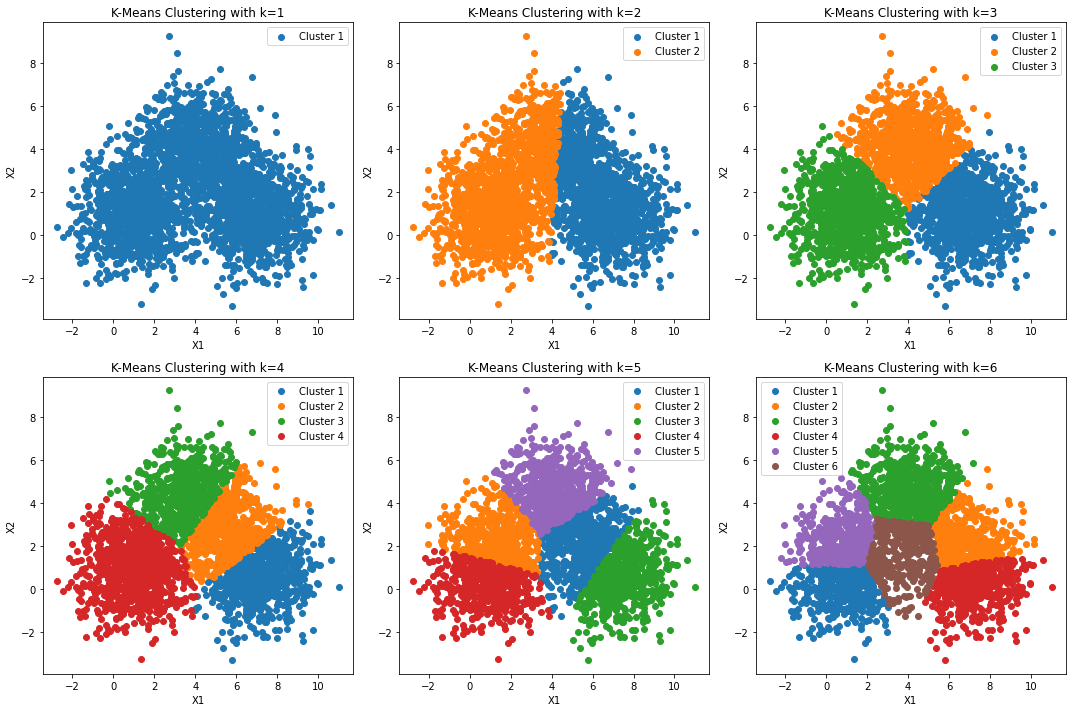

In [106]:
# Define a list of k values
k_values = [1, 2, 3, 4, 5, 6]

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df1_train.iloc[:, :2])  # Fit K-Means with k clusters

    # Get cluster assignments
    labels = kmeans.labels_

    # Plot data points with different colors for each cluster on the current subplot
    for cluster in range(k):
        cluster_data = df1_train[labels == cluster]
        axes[i].scatter(x=cluster_data.iloc[:, 0], y=cluster_data.iloc[:, 1], label=f'Cluster {cluster + 1}')

    # Set subplot titles and labels
    axes[i].set_title(f'K-Means Clustering with k={k}')
    axes[i].set_xlabel('X1')
    axes[i].set_ylabel('X2')

    # Add legend
    axes[i].legend()

# Tight layout to prevent overlapping
plt.tight_layout()

# Show the subplots
plt.show()

Applying the K-means clustering algorithm, we can obtain decent results if our estimation of k matches the number of clusters in the true ground truth labels. Furthermore, the plots also highlight one of the biggest weaknesses of K-means clustering: 'for each class, the other classes do not have a say in the positioning of the prototypes for that class.' This means that the clustering process is not capable of identifying the ground truth labels where clusters overlap each other.

#### d) Calucluate the clustering accuracy of the k-means method with k=3 based on the ground truth labels. You may choose any approach that you find appropriate.

In [107]:
from sklearn.metrics import accuracy_score

# Fit K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=0).fit(df1_train.iloc[:, :2])

# Get the cluster assignments
kmeans_labels = kmeans.labels_

# Calculate the clustering accuracy
accuracy = accuracy_score(df1_train.iloc[:, 2], kmeans_labels)
# accuracy = (df1_train.iloc[:, 2] == kmeans_labels).mean()

print(f'Clustering Accuracy: {accuracy * 100:.2f}%')

Clustering Accuracy: 30.33%


### Q2) Hierarchical Clustering

* In this question, we use NCI cancer cell line microarray data to study hierarchical clustering. The dataset contains expression levels on 6830 genes from 64 cancer cell lines as well as cancer types. 'Question2_features.csv' records a 64 by 6830 matrix of the expression values while 'Question2_labels.csv' is a vector listing the cancer types for the 64 cell lines.

* The linkage( ) function from scipy implements several clustering functions in python. Please refer to the following package for linkage:\
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html 
* To plot the hierarchical clustering as a dendrogram, please refer to the following package for dendrogram:\
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram

* The cut_tree( ) function cuts the dendrogram at certain height that will yields a particular number of clusters. Please refer to the following package for cut_tree:\
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cut_tree.html#scipy.cluster.hierarchy.cut_tree

In [108]:
df2 = pd.read_csv('./Question2_features.csv', index_col=0)
df2_labels = pd.read_csv('./Question2_labels.csv', index_col=0)

#### a) Perform hierarchical clustering of data using 'complete', 'single', and 'average' linkage clustering, with Euclidean distance as the dissimilarity measure.

In [109]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

# Perform hierarchical clustering with 'complete' linkage and Euclidean distance
complete_linkage = linkage(df2, method='complete', metric='euclidean')

# Perform hierarchical clustering with 'single' linkage and Euclidean distance
single_linkage = linkage(df2, method='single', metric='euclidean')

# Perform hierarchical clustering with 'average' linkage and Euclidean distance
average_linkage = linkage(df2, method='average', metric='euclidean')

#### b) Plot the dendrograms of different linkage clustering obtained in a). Let the labels of the x-axis be cancer types. What do you observe?

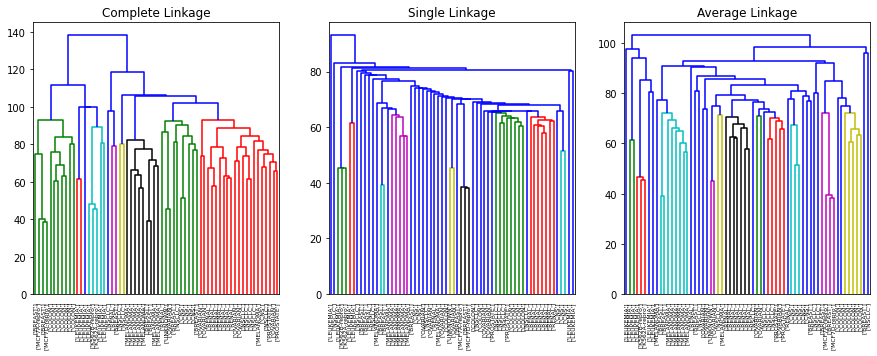

In [110]:
# Plot dendrograms for each clustering method
plt.figure(figsize=(15, 5))

plt.subplot(131)  # Subplot for complete linkage
dendrogram(complete_linkage, labels=df2_labels.values)
plt.title('Complete Linkage')

plt.subplot(132)  # Subplot for single linkage
dendrogram(single_linkage, labels=df2_labels.values)
plt.title('Single Linkage')

plt.subplot(133)  # Subplot for average linkage
dendrogram(average_linkage, labels=df2_labels.values)
plt.title('Average Linkage')

plt.show()

Overall, I think dendrograms can be compared to decision trees. At the bottom, we have the leaf nodes, each consisting of one data point. Going up from there, at every step, two children nodes merge into a parent node until we reach the root node of the tree. Looking at the three plots separately and in more detail (plotted them for the analysis in figsize=(15, 5)), I think the 'single linkage' method underperforms the 'complete linkage' and 'average linkage' when forming clusters. Furthermore, if we compare a cut for both the complete and average linkage dendrograms at the height that leads to four different clusters, we see that the complete linkage is by far the most detailed version, while the vast majority of labels in the average linkage are part of cluster 0.

####  c) Now let's use our 'complete' linkage hierarchical clustering for the analysis. Cut the dendrogram of complete linkage hierarchical clustering at the height that will yield 4 clusters. Provide a table to present the count of cancer cells of the same cancer type grouped within the same cluster.

In [111]:
# Perform hierarchical clustering with 'complete' linkage and Euclidean distance
complete_linkage = linkage(df2, method='complete', metric='euclidean')

# Cut the dendrogram at the height that yields 4 clusters
cluster_assignments = cut_tree(complete_linkage, n_clusters=4)

# Convert the cluster assignments to a DataFrame
cluster_df = pd.DataFrame({'Cluster': cluster_assignments.ravel(), 'Label': df2_labels.values.ravel()})

# Group and count the cancer cells within the same cluster and cancer type
result = cluster_df.groupby(['Cluster', 'Label']).size().reset_index(name='Count')

print(result)

    Cluster        Label  Count
0         0       BREAST      4
1         0          CNS      5
2         0     MELANOMA      8
3         0        NSCLC      8
4         0      OVARIAN      6
5         0     PROSTATE      2
6         0        RENAL      8
7         0      UNKNOWN      1
8         1       BREAST      1
9         1        NSCLC      1
10        1        RENAL      1
11        2  K562A-repro      1
12        2  K562B-repro      1
13        2     LEUKEMIA      6
14        3       BREAST      2
15        3        COLON      7
16        3  MCF7A-repro      1
17        3  MCF7D-repro      1


#### d) Apply the k-means clustering method to the dataset with k=4. How do these NCI60 k-means clustering results compare to what we get in c)?

In [112]:
# Perform K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=0).fit(df2)

# Get the cluster assignments from K-means
kmeans_labels = kmeans.labels_

# Create a DataFrame to store both K-means and hierarchical clustering results
cluster_results = pd.DataFrame({
    'K-Means': kmeans_labels,
    'Hierarchical': cluster_assignments.flatten(),  # Use the hierarchical clustering results from part (c)
    'Label': df2_labels.values.ravel()
})

# Compare the K-means and hierarchical clustering results
comparison = cluster_results.groupby(['K-Means', 'Hierarchical', 'Label']).size().reset_index(name='Count')

print(comparison)

    K-Means  Hierarchical        Label  Count
0         0             0       BREAST      2
1         0             0          CNS      5
2         0             0     MELANOMA      1
3         0             0        NSCLC      6
4         0             0      OVARIAN      6
5         0             0     PROSTATE      2
6         0             0        RENAL      8
7         0             0      UNKNOWN      1
8         0             1       BREAST      1
9         0             1        NSCLC      1
10        0             1        RENAL      1
11        1             2  K562A-repro      1
12        1             2  K562B-repro      1
13        1             2     LEUKEMIA      6
14        2             0       BREAST      2
15        2             0     MELANOMA      7
16        3             0        NSCLC      2
17        3             3       BREAST      2
18        3             3        COLON      7
19        3             3  MCF7A-repro      1
20        3             3  MCF7D-r

Comparing the two approaches, hierarchical and k-means clustering with four different labels, we can clearly see that the hierarchical clustering method is more capable than the K-means method in matching cancer cell labels with clusters. As an example, cluster 0 contains all of the 'NSCLC' labels in the hierarchical clustering, whereas k-means distributes them into two different clusters.

### Q3) Gaussian Mixture Models

* For this question, the dataset used for training is collected from three different Gaussian distributions. Each data point is in $\mathrm{R}^2$. We will use this dataset to study Gaussian mixture models.

* Please refer to the following package for Gaussian mixture models:\
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [113]:
df3_train = pd.read_csv('./Question3_training.csv')
df3_test = pd.read_csv('./Question3_testing.csv')

#### a) Learn Gaussian mixture models with k=1,2,3,4,5 clusters using the provided training dataset. Afterwards, compute the log-likelihood of the trained model based on the testing dataset. Finally, plot the log-likelihood vs. k. What do you observe? Which k will choose? Why? 

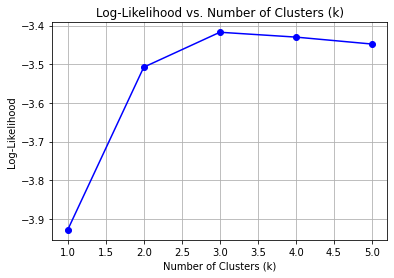

In [114]:
from sklearn.mixture import GaussianMixture
X_train, X_test = df3_train, df3_test

# Define a range of k values to try
k_values = [1, 2, 3, 4, 5]

# Initialize lists to store log-likelihoods
log_likelihoods = []

# Fit Gaussian mixture models for different values of k and calculate log-likelihood
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(X_train.iloc[:, :2])
    log_likelihood = gmm.score(X_test.iloc[:, :2])
    log_likelihoods.append(log_likelihood)

# Plot log-likelihood vs. k
plt.plot(k_values, log_likelihoods, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs. Number of Clusters (k)')
plt.grid(True)
plt.show()

According to the plot above, the log-likelihood is maximized when k=3 in the test set, which matches the number of labels in the original dataset. Therefore, ideally, we must choose k=3. However, the plot also shows that when we do not know the number of clusters in the ground truth labels, we should aim to slightly overshoot the number of clusters to achieve an overall higher score.

#### b) Apply the K-means method to the same training set with k=3. Then, apply the obtained centers to cluster the testing data set. Plot and color the data points in the testing set by the clustering results. 

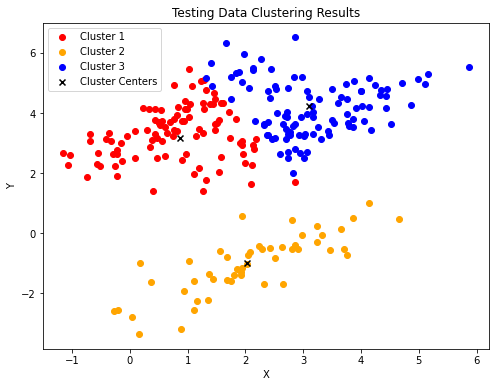

In [115]:
# Apply K-means clustering to the training data with k=3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train.iloc[:, :2])

# Get the cluster centers and labels for the testing data
cluster_centers = kmeans.cluster_centers_
test_labels = kmeans.predict(X_test.iloc[:, :2])

# Create a scatter plot for the testing data
plt.figure(figsize=(8, 6))
plt.title('Testing Data Clustering Results')
plt.xlabel('X')
plt.ylabel('Y')

# Define colors for the clusters
colors = ['r', 'orange', 'b']

# Plot data points in the testing set and color them by cluster
for i in range(3):
    cluster_data = X_test[test_labels == i] # does the slicing works just fine?
    plt.scatter(x=cluster_data.iloc[:, 0], y=cluster_data.iloc[:, 1], c=colors[i], label=f'Cluster {i + 1}')

# Plot cluster centers
plt.scatter(cluster_centers[:, 0], y=cluster_centers[:, 1], c='k', marker='x', label='Cluster Centers')

# Add legend
plt.legend()

plt.show()

#### c) Repeat the process in b) using the Gaussian mixture model for k=3 in a). What do you observe when comparing the outputs of the K-means and Gaussian mixture models? Why?

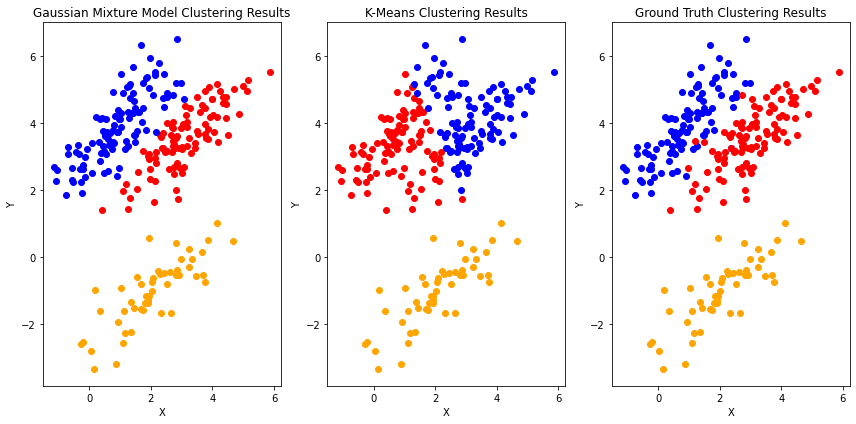

In [116]:
# Apply Gaussian Mixture model clustering to the training data with k=3
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X_train.iloc[:, :2])

# Get the cluster assignments for the testing data
gmm_labels = gmm.predict(X_test.iloc[:, :2])

# Apply K-means clustering to the training data with k=3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train.iloc[:, :2])

# Get the cluster assignments for the testing data
kmeans_labels = kmeans.predict(X_test.iloc[:, :2])

# Create scatter plots for the testing data for both methods
plt.figure(figsize=(12, 6))

# Gaussian Mixture Model
plt.subplot(1, 3, 1)
plt.title('Gaussian Mixture Model Clustering Results')
plt.xlabel('X')
plt.ylabel('Y')

# Define colors for the clusters
colors = ['r', 'orange', 'b']

for i in range(3):
    cluster_data = X_test[gmm_labels == i]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f'Cluster {i + 1}')

# K-Means
plt.subplot(1, 3, 2)
plt.title('K-Means Clustering Results')
plt.xlabel('X')
plt.ylabel('Y')

for i in range(3):
    cluster_data = X_test[kmeans_labels == i]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f'Cluster {i + 1}')

plt.subplot(1, 3, 3)
plt.title('Ground Truth Clustering Results')
plt.xlabel('X')
plt.ylabel('Y')

ground_truth_colors = ['b', 'r', 'orange']

for i in range(3):
    cluster_data = df3_test[df3_test.iloc[:, 2] == i]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=ground_truth_colors[i], label=f'Cluster {i + 1}')

plt.tight_layout()
plt.show()

The Gaussian Mixture Model (GMM) is often referred to as a soft clustering method, while K-means is a hard one. Therefore, when comparing GMM to the K-means clustering method, we can see that the decision boundary of GMM is much smoother and allows for more flexibility, whereas the K-means algorithm has harder boundaries. That being said, when k=3, both methods are capable of classifying the 'orange' labels (i=2) correctly. Overall, I think GMM is the more ideal clustering method for this dataset, which could also be due to the fact that the underlying dataset is from different Gaussian distributions (one of the assumptions of GMM).

### Q4) Graph Clustering

* In this question, a 100 by 100 adjacency matrix of 100 nodes is given to study graph clustering method.

* Please refer to the following package for spectral clustering:\
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.spectral_clustering.html

* You can use the package networkx to build and draw graphs. To create a graph from the adjacency matrix, please refer to the following function:\
https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html

* To draw network graphs, please refer to the following function draw_networkx:\
https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

In [117]:
df4 = pd.read_csv('./Question4.csv', index_col=0)

#### a) Plot 100 nodes of the given adjacency matrix, and the nodes are expected to be evenly distributed on a unit circle.

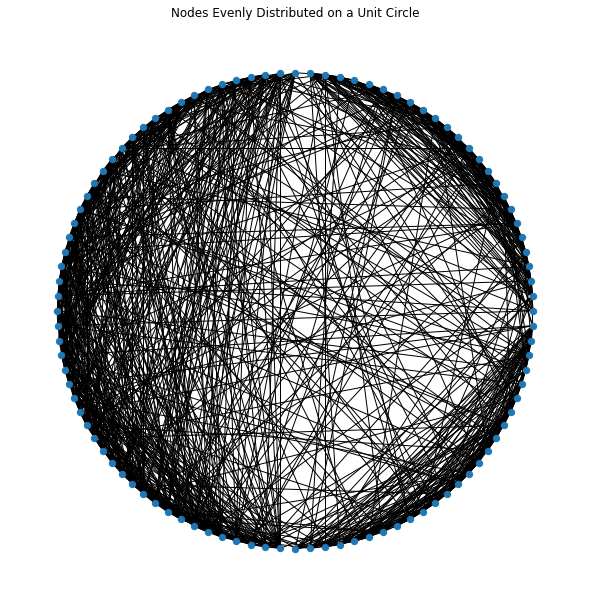

In [118]:
import networkx as nx

adjacency_matrix = np.matrix(df4)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Create positions for the nodes on a unit circle
positions = {node: (np.cos(2 * np.pi * node / 100), np.sin(2 * np.pi * node / 100)) for node in G.nodes}

# Draw the graph with nodes evenly distributed on a unit circle
plt.figure(figsize=(8, 8))
nx.draw(G, pos=positions, with_labels=False, node_size=40)
plt.title('Nodes Evenly Distributed on a Unit Circle')
plt.axis('off')
plt.show()

#### b) Apply the spectral clustering to the given adjacency matrix with k=2,3,4 clusters. Plot the graph using the positions from a), and color the nodes by the clustering results. 

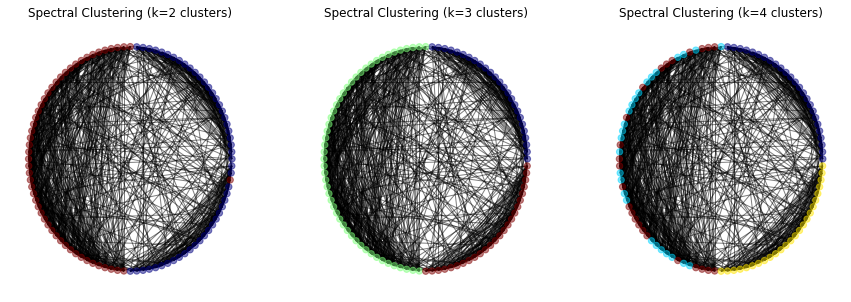

In [119]:
from sklearn.cluster import SpectralClustering

adjacency_matrix = np.matrix(df4)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Create positions for the nodes on a unit circle (from part a)
positions = {node: (np.cos(2 * np.pi * node / 100), np.sin(2 * np.pi * node / 100)) for node in G.nodes}

# Apply spectral clustering with k=2,3,4
k_values = [2, 3, 4]
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    spectral_clustering = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=0)
    cluster_labels = spectral_clustering.fit_predict(adjacency_matrix)

    # Draw the graph with nodes colored by the clustering results
    ax = axes[i]
    ax.set_title(f'Spectral Clustering (k={k} clusters)')
    colors = [cluster_labels[node] for node in G.nodes]
    nx.draw(G, pos=positions, node_color=colors, cmap=plt.get_cmap('jet'), with_labels=False, node_size=40, alpha=0.50, ax=ax)
    ax.axis('off')

plt.show()

#### c) Based on the clustering results in b), which k will you choose?

According to my interpretation of the three plots above, I believe that k=3 does an excellent job when spectral clustering is applied to the given dataset. The connections between the nodes mainly occur in three distinct regions. However, when we increase k to 4, it becomes evident that the accuracy of the clustering is decreasing.

### Q5) Spectral Clustering

* For this question, the dataset is generated using the make_moons( ) function of scikit-learn, which makes two interleaving half circles. Each data point is in $\mathrm{R}^2$ and belongs to one of the harf circles. We will use this dataset to study spectral clustering.

* Please refer to the following package for spectral clustering:\
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

* To generate adjancency matrix using q nearest neighbors, please refer to the following package:\
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

In [120]:
df5 = pd.read_csv('./Question5.csv')

#### a) Generate adjacency matrices of the nodes by q nearest neighbors with q=5,10,20,40. Plot the obtained graph using the positions of the data points. Please compare the results. Which q's will you choose? Why?

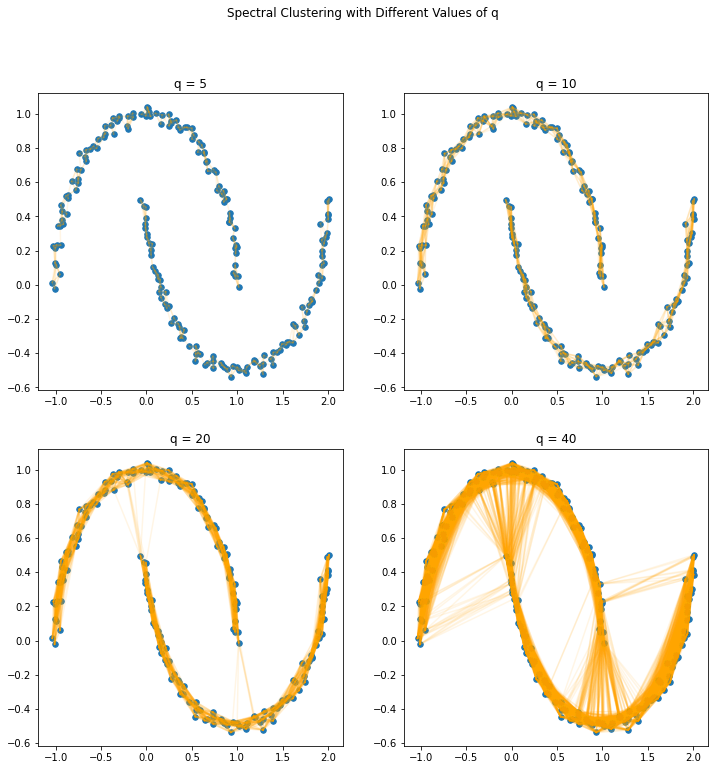

In [121]:
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph

# Generate the dataset
# X, _ = make_moons(n_samples=200, noise=0.025, random_state=0)

# Generate the dataset
X, _ = df5.iloc[:, :2].to_numpy(), df5.iloc[:, 2]

# Define a list of q values to try
q_values = [5, 10, 20, 40]

# Create subplots for plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Spectral Clustering with Different Values of q")

for i, q in enumerate(q_values):
    # Generate the adjacency matrix using q nearest neighbors
    adjacency_matrix = kneighbors_graph(X, n_neighbors=q, mode='connectivity', include_self=True)

    # Plot the graph using the positions of the data points
    ax = axes[i // 2, i % 2]
    ax.set_title(f'q = {q}')
    ax.scatter(X[:, 0], X[:, 1], c='C0', s=30, label='Data Points', edgecolors='C0')
    for j in range(len(X)):
        for k in range(len(X)):
            if adjacency_matrix[j, k] == 1:
                ax.plot([X[j, 0], X[k, 0]], [X[j, 1], X[k, 1]], 'orange', alpha=0.10)

plt.show()

If we compare the four different values for the number of neighbors (q), I think that a value up to ten is reasonable. This proposition is based on the fact that the upper U-shape and the lower U-shape can still be differentiated in that way. If we further increase the value of q, the nodes start to connect in a way that does not make much sense when we think about clustering.

#### b) Apply the spectral clustering to the obtain graphs with q=5,10,20,40. Plot and color all data points by the clustering results. Which q's will you choose? Are they same as your answer in a)? Why?

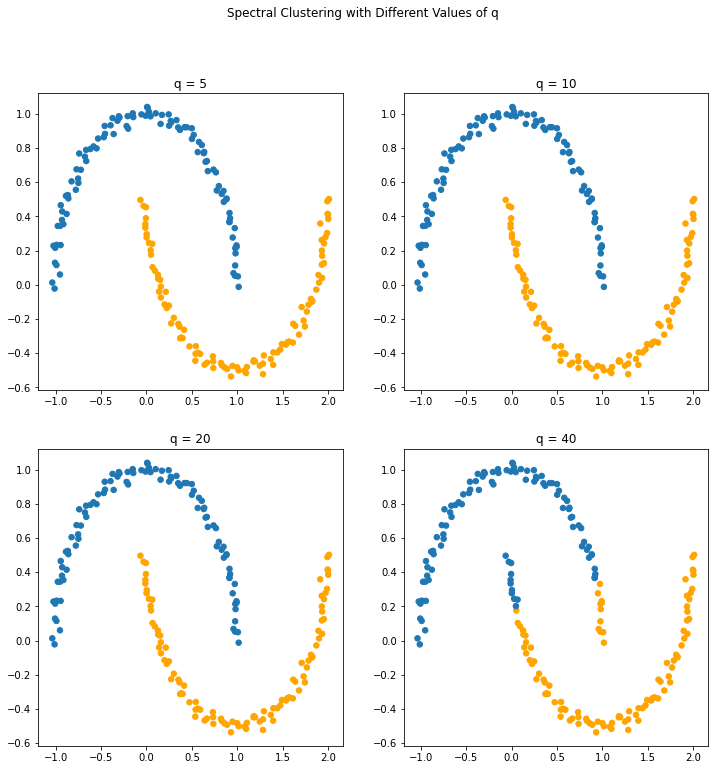

In [122]:
q_values = [5, 10, 20, 40]

# Create subplots for plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Spectral Clustering with Different Values of q")

for i, q in enumerate(q_values):
    # Generate the adjacency matrix using q nearest neighbors
    adjacency_matrix = kneighbors_graph(X, n_neighbors=q, mode='connectivity', include_self=True)

    # Apply spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)
    cluster_labels = spectral_clustering.fit_predict(adjacency_matrix)

    # Plot the data points colored by the clustering results using blue (C0) and orange
    ax = axes[i // 2, i % 2]
    ax.set_title(f'q = {q}')
    colors = ['C0' if label == 0 else 'orange' for label in cluster_labels]
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=30)

plt.show()

After applying spectral clustering with the same four different q values (q_values = [5, 10, 20, 40]), I would apply the same reasoning as in part 'a' to 'b'. A value of q <= 10 seems to work just fine, as it still differentiates the two clusters as before. However, when using spectral clustering, we could even increase it to 20, as the blurring of the upper U-shape with the lower U-shape starts to occur around q = 40. In that sense, the spectral clustering method seems to be more robust than than just the adjacency matrixes with q nearest neighbors.

#### c) Generate a weighted adjancency matrix using $h(z)=\exp(-\gamma*z^{2})$, and apply the spectral clustering to the obtained adjacency matrix. Plot and color all data points by the clustering results. Take $\gamma \in \{10^{0},10^1,\ldots,10^{4}\}$.

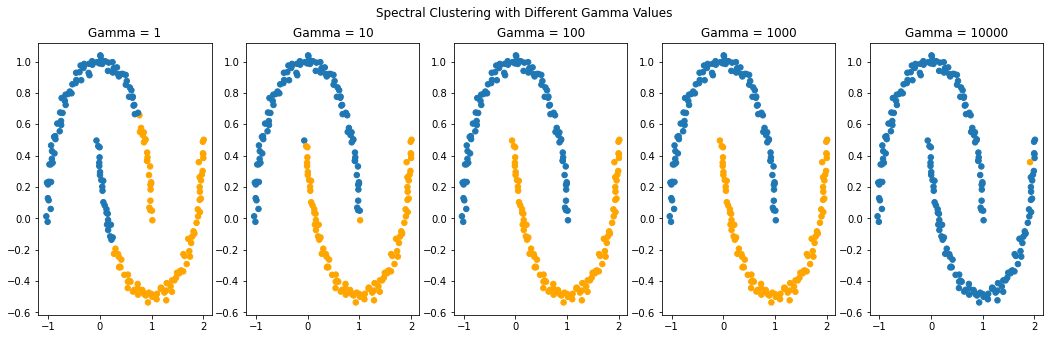

In [123]:
# Create a function for generating the weighted adjacency matrix
def generate_weighted_adjacency_matrix(X, gamma):
    n = len(X)
    adjacency_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance = np.linalg.norm(X[i] - X[j])  # Euclidean distance
                weight = np.exp(-gamma * distance**2)
                adjacency_matrix[i, j] = weight
    return adjacency_matrix

# Define a list of gamma values
gamma_values = [10**i for i in range(5)]  # [1, 10, 100, 1000, 10000]

# Apply spectral clustering for each gamma and plot the results
fig, axes = plt.subplots(1, len(gamma_values), figsize=(18, 5))
fig.suptitle("Spectral Clustering with Different Gamma Values")

for i, gamma in enumerate(gamma_values):
    # Generate the weighted adjacency matrix
    adjacency_matrix = generate_weighted_adjacency_matrix(X, gamma)

    # Apply spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)
    cluster_labels = spectral_clustering.fit_predict(adjacency_matrix)

    # Plot the graph with nodes colored by the clustering results
    ax = axes[i]
    ax.set_title(f'Gamma = {gamma}')
    colors = ['C0' if label == 0 else 'orange' for label in cluster_labels]
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=30)


plt.show()

#### d) Generate a weighted adjancency matrix using $h(z)=(z^{2}+1)^{-\gamma}$, and apply the spectral clustering to the obtained adjacency matrix. Plot and color all data points by the clustering results. Take $\gamma \in \{10^{0},10^1,\ldots,10^{4}\}$.

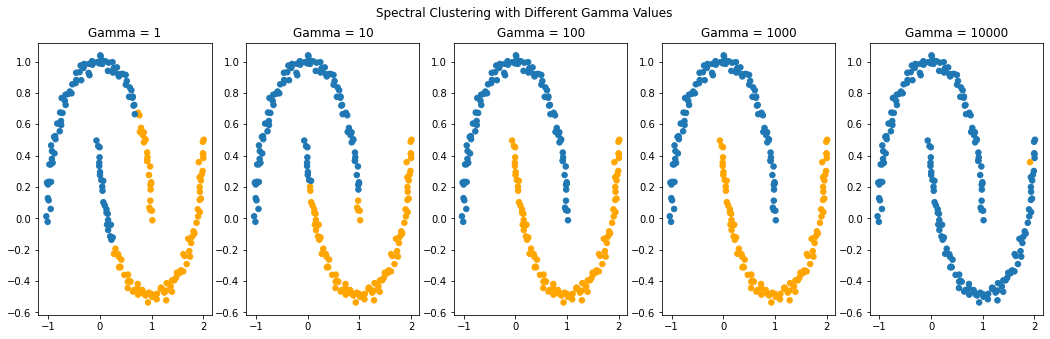

In [124]:
# Create a function for generating the weighted adjacency matrix
def generate_weighted_adjacency_matrix(X, gamma):
    n = len(X)
    adjacency_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance = np.linalg.norm(X[i] - X[j])  # Euclidean distance
                weight = (distance**2 + 1)**(-gamma)
                adjacency_matrix[i, j] = weight
    return adjacency_matrix

# Define a list of gamma values
gamma_values = [10**i for i in range(5)]  # [1, 10, 100, 1000, 10000]

# Apply spectral clustering for each gamma and plot the results
fig, axes = plt.subplots(1, len(gamma_values), figsize=(18, 5))
fig.suptitle("Spectral Clustering with Different Gamma Values")

for i, gamma in enumerate(gamma_values):
    # Generate the weighted adjacency matrix
    adjacency_matrix = generate_weighted_adjacency_matrix(X, gamma)

    # Apply spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)
    cluster_labels = spectral_clustering.fit_predict(adjacency_matrix)

    # Plot the graph with nodes colored by the clustering results
    ax = axes[i]
    ax.set_title(f'Gamma = {gamma}')
    colors = ['C0' if label == 0 else 'orange' for label in cluster_labels]
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=30)


plt.show()